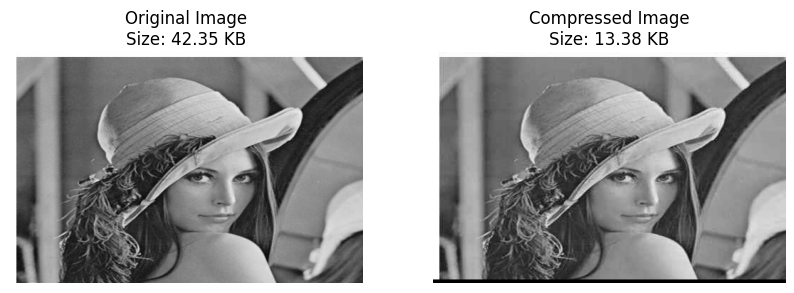

Original Size: 43367 bytes
Compressed Size: 13704 bytes
Compression Ratio: 316.46%


In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
#lossy compression
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def divide_into_blocks(image, block_size=8):
    h, w = image.shape
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            if block.shape == (block_size, block_size):
                blocks.append(block)
    return blocks

def apply_dct(block):
    return cv2.dct(np.float32(block))

def quantize(block, q_matrix, scale_factor=1.5):  # Adjust for better compression
    return np.round(block / (q_matrix * scale_factor))

def dequantize(block, q_matrix, scale_factor=1.5):
    return block * (q_matrix * scale_factor)

def apply_idct(block):
    return cv2.idct(np.float32(block))

def merge_blocks(blocks, image_shape, block_size=8):
    h, w = image_shape
    reconstructed_image = np.zeros((h, w))
    block_index = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            if block_index < len(blocks):
                reconstructed_image[i:i + block_size, j:j + block_size] = blocks[block_index]
                block_index += 1
            else:
                break
    return np.clip(reconstructed_image, 0, 255)

# Load and preprocess image
image = cv2.imread('input.jpg', cv2.IMREAD_GRAYSCALE)
original_size = os.path.getsize('input.jpg')  # Get actual file size in bytes

blocks = divide_into_blocks(image)

# JPEG standard quantization matrix
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Apply DCT and quantization
dct_blocks = [apply_dct(block) for block in blocks]
quantized_blocks = [quantize(block, quant_matrix) for block in dct_blocks]

# Decompression (Dequantization + IDCT)
dequantized_blocks = [dequantize(block, quant_matrix) for block in quantized_blocks]
reconstructed_blocks = [apply_idct(block) for block in dequantized_blocks]

# Convert back to uint8
reconstructed_image = merge_blocks(reconstructed_blocks, image.shape)
compressed_image_uint8 = np.uint8(reconstructed_image)

# Save compressed image as JPEG
cv2.imwrite("compressed.jpg", compressed_image_uint8, [cv2.IMWRITE_JPEG_QUALITY, 50])  # Set JPEG Quality to 50%

# Get actual compressed size
compressed_size = os.path.getsize("compressed.jpg")

# Compute Compression Ratio
compression_ratio = (original_size / compressed_size) * 100

# Display images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title(f"Original Image\nSize: {original_size / 1024:.2f} KB")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(compressed_image_uint8, cmap='gray')
plt.title(f"Compressed Image\nSize: {compressed_size / 1024:.2f} KB")
plt.axis('off')

plt.show()

print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")
print(f"Compression Ratio: {compression_ratio:.2f}%")


Original Image Size: 92.79 KB
Compressed Image Size: 48.22 KB
Compression Ratio: 1.92


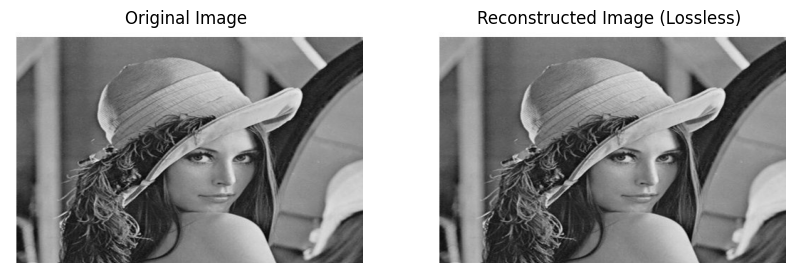

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
#lossless compression
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Load the image
image_path = "input.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path.")
    exit()

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Apply DCT
dct_image = blockwise_dct(padded_image)

# Apply Inverse DCT (without quantization)
image_reconstructed = blockwise_idct(dct_image)

# Remove padding
image_reconstructed = image_reconstructed[:h, :w]

# Clip values and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Save and compare file sizes
original_image_path = "image.png"
cv2.imwrite(original_image_path, image)

compressed_image_path = "compressed_lossless.jpg"
cv2.imwrite(compressed_image_path, image_reconstructed)

original_size = os.path.getsize(original_image_path)
compressed_size = os.path.getsize(compressed_image_path)

print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size: {compressed_size / 1024:.2f} KB")
print(f"Compression Ratio: {original_size / compressed_size:.2f}")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Reconstructed Image (Lossless)')
plt.axis('off')

plt.show()


Original Image Size: 48.21 KB
Compressed Image Size: 48.17 KB
Compression Ratio: 1.00


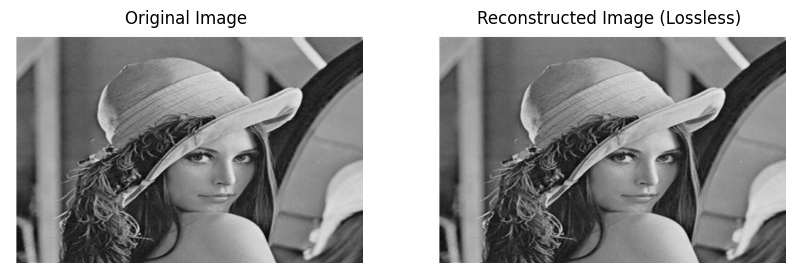

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
#lossless compression
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Load the image
image_path = "input.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path.")
    exit()

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Apply DCT
dct_image = blockwise_dct(padded_image)

# Apply Inverse DCT (without quantization)
image_reconstructed = blockwise_idct(dct_image)

# Remove padding
image_reconstructed = image_reconstructed[:h, :w]

# Clip values and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Save and compare file sizes
original_image_path = "input.jpg"
cv2.imwrite(original_image_path, image)

compressed_image_path = "compressed_lossless.jpg"
cv2.imwrite(compressed_image_path, image_reconstructed)

original_size = os.path.getsize(original_image_path)
compressed_size = os.path.getsize(compressed_image_path)

print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size: {compressed_size / 1024:.2f} KB")
print(f"Compression Ratio: {original_size / compressed_size:.2f}")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Reconstructed Image (Lossless)')
plt.axis('off')

plt.show()


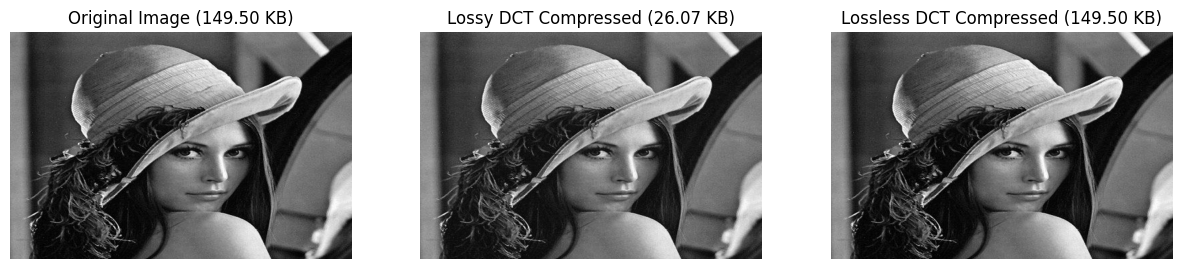

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def dct2(block):
    return cv2.dct(np.float32(block))

def idct2(block):
    return cv2.idct(np.float32(block))

def apply_dct_compression(image, quantization_factor=10):
    h, w = image.shape
    compressed_image_lossy = np.zeros((h, w))
    compressed_image_lossless = np.zeros((h, w))

    block_size = 8
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct2(block)

            # Lossy compression (Quantization)
            quantized_dct = np.round(dct_block / quantization_factor) * quantization_factor
            lossy_block = idct2(quantized_dct)

            # Lossless compression (keeping all DCT coefficients)
            lossless_block = idct2(dct_block)

            compressed_image_lossy[i:i+block_size, j:j+block_size] = lossy_block
            compressed_image_lossless[i:i+block_size, j:j+block_size] = lossless_block

    return compressed_image_lossy, compressed_image_lossless

# Load image and convert to grayscale
image_path = 'input.png'  # Replace with your actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply DCT compression
lossy, lossless = apply_dct_compression(image, quantization_factor=10)

# Save images to disk
cv2.imwrite("lossy.jpg", lossy, [cv2.IMWRITE_JPEG_QUALITY, 50])  # JPEG for lossy
cv2.imwrite("lossless.png", lossless)  # PNG for lossless
cv2.imwrite("original.png", image)  # Save original for size comparison

# Get file sizes
original_size = os.path.getsize("original.png") / 1024  # Convert to KB
lossy_size = os.path.getsize("lossy.jpg") / 1024
lossless_size = os.path.getsize("lossless.png") / 1024

# Display original, lossy, and lossless images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title(f"Original Image ({original_size:.2f} KB)")

axes[1].imshow(lossy, cmap='gray')
axes[1].set_title(f"Lossy DCT Compressed ({lossy_size:.2f} KB)")

axes[2].imshow(lossless, cmap='gray')
axes[2].set_title(f"Lossless DCT Compressed ({lossless_size:.2f} KB)")

for ax in axes:
    ax.axis("off")
plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8824 - loss: 0.3697 - val_accuracy: 0.9787 - val_loss: 0.0657
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9836 - loss: 0.0529 - val_accuracy: 0.9856 - val_loss: 0.0467
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9880 - loss: 0.0367 - val_accuracy: 0.9840 - val_loss: 0.0553
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9911 - loss: 0.0281 - val_accuracy: 0.9897 - val_loss: 0.0413
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9935 - loss: 0.0205 - val_accuracy: 0.9893 - val_loss: 0.0427
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 0.9858 - val_loss: 0.0477
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9958 - loss: 0.0126 - val_accuracy: 0.9883 - val_loss: 0.0443
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9966 - loss: 0.0105 

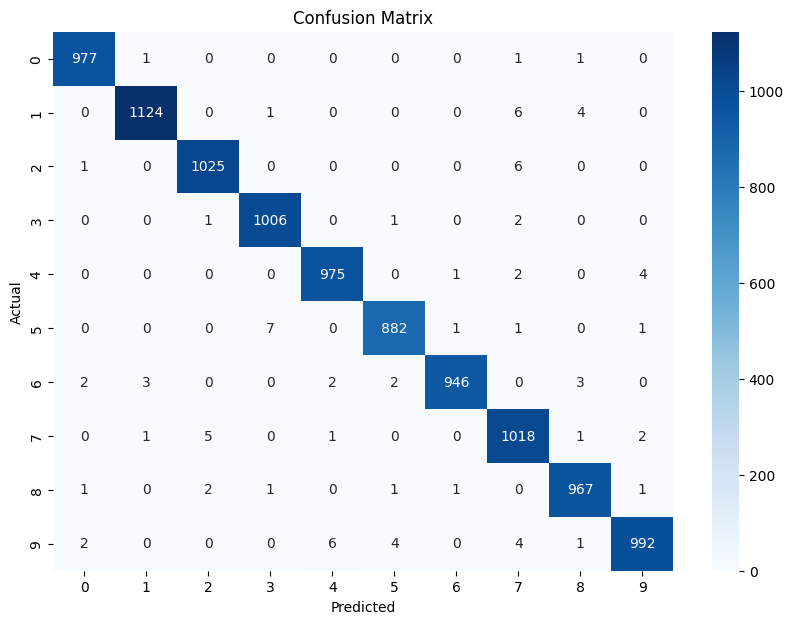

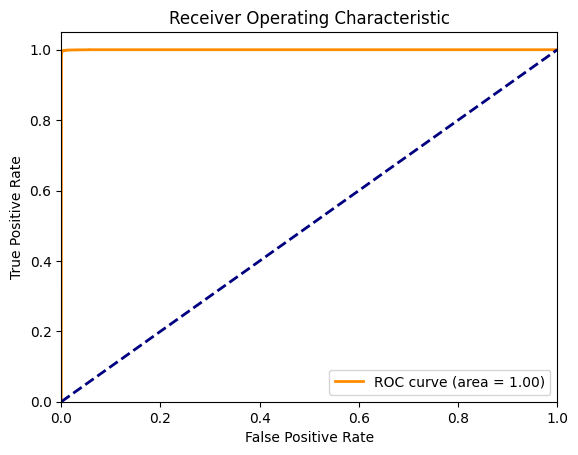

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC Curve and AUC
y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=10)
fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.5612 - loss: 1.7009 - val_accuracy: 0.9237 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8875 - loss: 0.5998 - val_accuracy: 0.9462 - val_loss: 0.3863 - learning_rate: 0.0010
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9164 - loss: 0.4792 - val_accuracy: 0.9557 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9261 - loss: 0.4115 - val_accuracy: 0.9533 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9340 - loss: 0.3765 - val_accuracy: 0.9613 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9356 - loss: 0.3653 - val_accuracy: 0.9636 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.9389 - loss: 0.3529

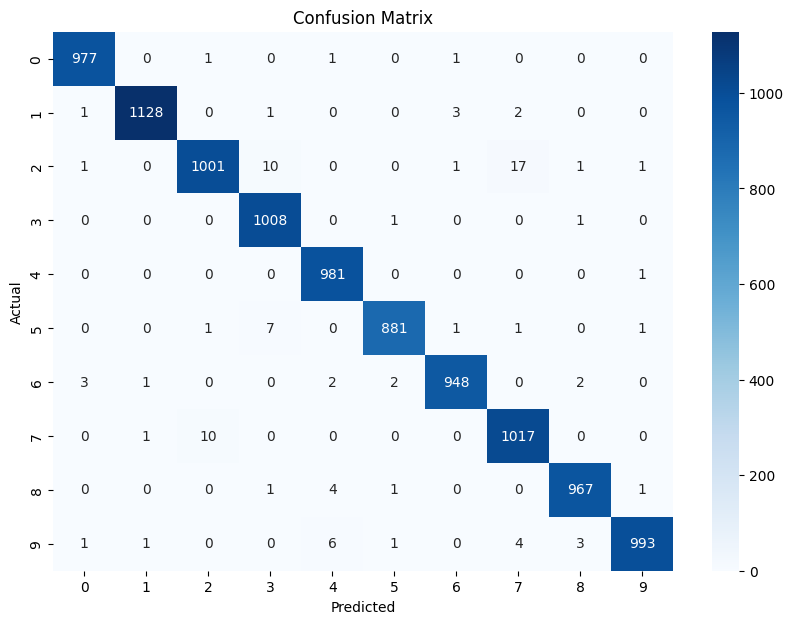

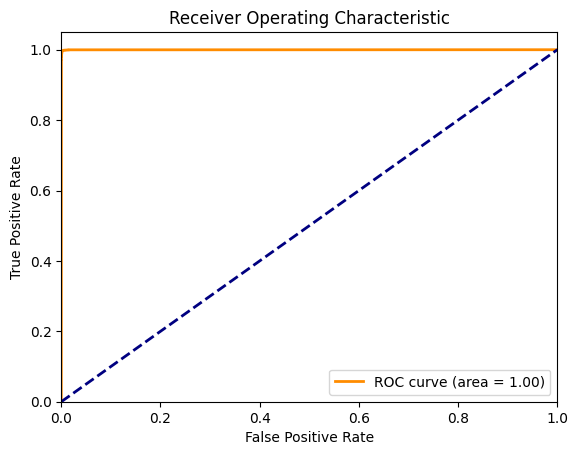

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Reshape and normalize the pixel values
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# Data Augmentation (limited for grayscale images)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(x_train)

# Define the improved CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# Manually split the data for validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # Split data for validation

history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=50,
                    validation_data=datagen.flow(x_val, y_val, batch_size=64), # Use validation_data instead of validation_split
                    callbacks=[reduce_lr, early_stopping])

# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC Curve and AUC
y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=10)
fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3328 - loss: 1.7971 - val_accuracy: 0.5234 - val_loss: 1.3134
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5526 - loss: 1.2394 - val_accuracy: 0.6044 - val_loss: 1.1145
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6294 - loss: 1.0457 - val_accuracy: 0.6373 - val_loss: 1.0314
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6700 - loss: 0.9425 - val_accuracy: 0.6742 - val_loss: 0.9340
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6999 - loss: 0.8476 - val_accuracy: 0.6943 - val_loss: 0.9042
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7240 - loss: 0.7827 - val_accuracy: 0.6930 - val_loss: 0.9000
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7448 - loss: 0.7248 - val_accuracy: 0.7083 - val_loss: 0.8478
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7654 - loss: 0.6734 

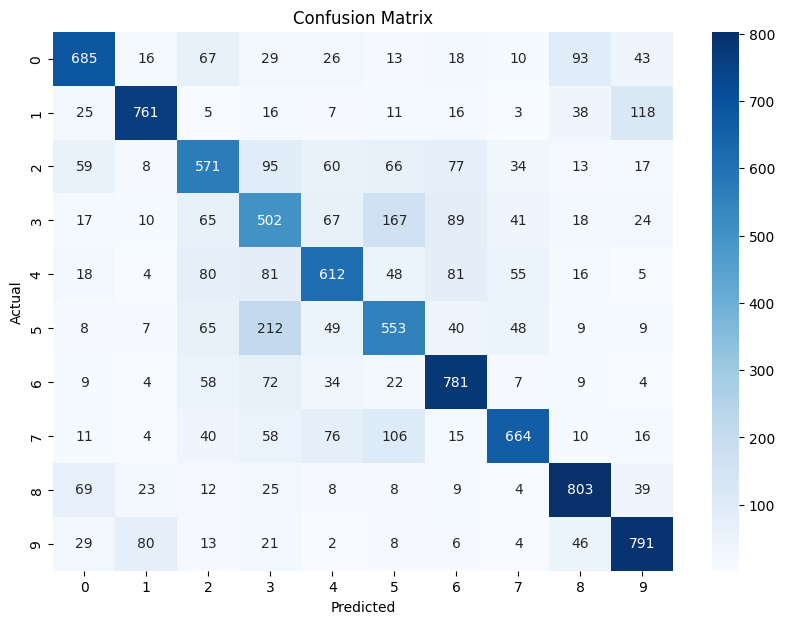

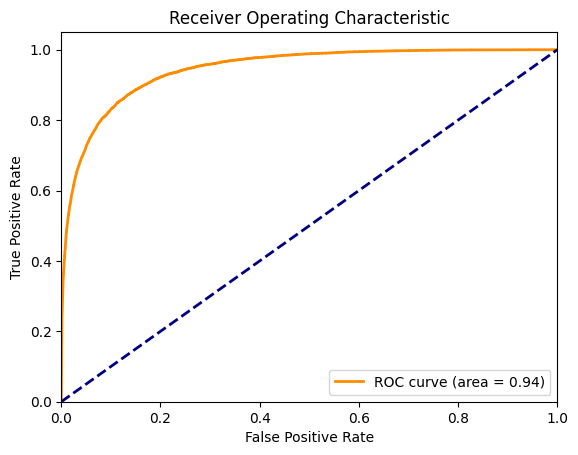

In [ ]:
#Anshika Gupta: E22CSEU0921: Batch-31
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC Curve and AUC
y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=10)
fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
